## Introduction

COVID-19, along with many respiratory viruses, is airborne [[1](https://www.science.org/doi/10.1126/science.abd9149)]. That means that they don't suddenly fall into the ground when emitted by an infectious person. They float in the air, and stay there for a long period of time, like smoke. The airborne nature of the virus has led to indoor air quality experts Richard Corsi & Jim Rosenthal to share their design of a simple Do-It-Yourself (DIY) air cleaner. The design involves taping a 20-inch-by-20-inch box fan to a box of air filters, which are called Corsi-Rosenthal (CR) boxes [[Clean Air Crew](https://cleanaircrew.org/boxfanfilterfaq/)]. A [UC Davis](https://energy.ucdavis.edu/wp-content/uploads/Case-Study_DIY-Portable-Air-Cleaners-083121.pdf) study shows that CR boxes are as effective in cleaning the air, while being a third of the cost of commercial air cleaners.

In 2020, some researchers studied the effectiveness of different cloth fabrics on filtration efficiency for masks [[[Konda](https://pubs.acs.org/doi/10.1021/acsnano.0c03252)], [[Hao](https://www.sciencedirect.com/science/article/pii/S1438463920305289?via%3Dihub)], [[Yang](https://docs.google.com/spreadsheets/d/17aJQn-zmhBWO9vlgfWQLAuRUNrxrUnE8Ftm2wUHlddI/edit#gid=0)]]. In Yang's research, they found that one layer of Rubbermaid microfiber has a filtration efficiency of about 46%, assuming an average inhalation rate of 60 liters per minute.

## An equation for PM removal over time

Let $A$ represent the actual PM level, $t$ be the time in seconds, $d$ be the decaying factor (a fraction between 0 and 1), $c$ be the cubic feet per second output, and $v$ be the volume of the room (in cubic feet):

$$
\begin{equation}
\begin{aligned}
  A_{t+1} &= A_{t} \cdot (1-d)^{\frac{c}{v}}
\end{aligned}
\end{equation}
$$


$d$ can be broken into two parts. If the air cleaner is turned on, the
filtration efficiency of the filter, along with natural decay.

$$
\begin{equation}
\begin{aligned}
d(\text{air cleaner := on}) = d_{\text{filtration efficiency}} + d_{\text{natural}}
\end{aligned}
\end{equation}
$$

If the air cleaner is turned off, then the filtration efficiency of the filter does not apply, so
$d$ gets set to the natural decay:

$$
\begin{equation}
\begin{aligned}
d(\text{air cleaner := off}) = d_{\text{natural}}
\end{aligned}
\end{equation}
$$

Thus, we can infer the filtration efficiency by running an experiment with the air cleaner on and with the air cleaner off. We could then subtract $d(\text{air cleaner := off})$ from  $d(\text{air cleaner := on})$ to get $d_{\text{filtration efficiency}}$.



$$
\begin{equation}
\begin{aligned}
d(\text{air cleaner := on}) - d(\text{air cleaner := off}) &= d_{\text{filtration efficiency}} + d_{\text{natural}} - d_{\text{natural}}\\
&= d_{\text{filtration efficiency}}
\end{aligned}
\end{equation}
$$


## Estimating the flow rate of the air cleaner

In [3]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt

from linx.ds import BayesianNetwork as BN, \
    ConditionalProbabilityTable as CPT, \
    Query
from linx.infer import VariableElimination as VE

In [4]:
def miles_per_hour_to_feet_per_second(mph):
    """
    Miles per hour * 5280 feet / mile * 3600 sec / hour
    """
    return mph * 5280.0 / 3600

In [5]:
def circle_area(diameter):
    """
    Returns area of circle
    """
    radius = diameter / 2
    return np.pi * radius ** 2

In [6]:
miles_per_hour_to_feet_per_second(2)

2.933333333333333

In [7]:
def surface_area_of_layer_in_sq_ft(
    layer,  
    num_layers,
    no_air_flow_middle_diam_inches, 
    with_air_flow_inches
):
    """
    Assuming 5 layers.
    
    1st layer is layer 0.
    
    Parameters:
        layer: integer
        
        num_layers: integer
            The number of circular layers.
            
        no_air_flow_middle_diam_inches: float
            This is the area of the circle that has no airflow, due to the design of 
            the box fan (i.e. some circle with a box fan logo). Measured in inches.
        
        with_air_flow_inches: float
            When added to no_air_flow_middle_diam_inches, we get a diameter, whose 
            circumference corresponds to the circle in which air is coming out of.
            
        
    Returns: float
        square-feet
    """
    num_inches_in_a_foot = 12
    
    if layer < 0 or layer > num_layers - 1:
        raise ValueError(f"Layer {layer} cannot be less than 0 or greater than 2.")
        
    engulfing_circle_area = circle_area(
        (
            no_air_flow_middle_diam_inches + (layer + 1) * with_air_flow_inches / num_layers
        ) / num_inches_in_a_foot
    )
    
    engulfed_circle_area = circle_area(
        (
            no_air_flow_middle_diam_inches + layer * with_air_flow_inches / num_layers
        ) / num_inches_in_a_foot
    )
    
    return (engulfing_circle_area - engulfed_circle_area)

In [8]:
surface_area_of_layer_in_sq_ft(
    layer=0,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.1987736092549097

In [9]:
np.pi * ((8.0 * 1/3 + 5.5) / (12 * 2))**2 - (np.pi * (5.5 / (2 * 12)) ** 2)

0.1987736092549097

In [10]:
surface_area_of_layer_in_sq_ft(
    layer=1,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.27634379823243543

In [11]:
np.pi * ((8.0 * 2/3 + 5.5) / (12 * 2))**2 - np.pi * ((8.0 * 1/3 + 5.5) / (12 * 2))**2

0.27634379823243543

In [12]:
surface_area_of_layer_in_sq_ft(
    layer=2,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.35391398720996137

In [13]:
np.pi * ((8.0 + 5.5) / (12 * 2))**2 - np.pi * ((8.0 * 2/3 + 5.5) / (12 * 2))**2

0.35391398720996137

In [14]:
airflow_areas = [
    surface_area_of_layer_in_sq_ft(
        layer=layer,
        num_layers=3,
        no_air_flow_middle_diam_inches=5.5,
        with_air_flow_inches=8.0
    )
    for layer in range(3)
]

In [15]:
sum(airflow_areas)

0.8290313946973065

In [16]:
num_divisions = 12.0
surface_area_of_layer_in_sq_ft(
    layer=1,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
) / num_divisions

0.02302864985270295

In [17]:
anemometer_readings = pd.DataFrame([
    {
        'layer': 0,
        'group': 0,
        'reading': 0.4
    },
    {
        'layer': 0,
        'group': 0,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 1,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 1,
        'reading': 1.6
    },
    {
        'layer': 0,
        'group': 2,
        'reading': 1.1
    },
    {
        'layer': 0,
        'group': 2,
        'reading': 1.1
    },
    {
        'layer': 0,
        'group': 3,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 4,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 4,
        'reading': 0.9
    },
    {
        'layer': 0,
        'group': 5,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 5,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 6,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 6,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 7,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 7,
        'reading': 0.4
    },
    {
        'layer': 0,
        'group': 8,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 8,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 9,
        'reading': 1.5
    },
    {
        'layer': 0,
        'group': 9,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 10,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 10,
        'reading': 1.7
    },
    {
        'layer': 0,
        'group': 11,
        'reading': 1.6
    },
    {
        'layer': 0,
        'group': 11,
        'reading': 1.0
    },

    {
        'layer': 1,
        'group': 0,
        'reading': 2.8
    },
    {
        'layer': 1,
        'group': 0,
        'reading': 2.1
    },
    {
        'layer': 1,
        'group': 1,
        'reading': 2.7
    },
    {
        'layer': 1,
        'group': 1,
        'reading': 2.1
    },
    {
        'layer': 1,
        'group': 2,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 2,
        'reading': 2.2
    },
    {
        'layer': 1,
        'group': 3,
        'reading': 3.0
    },
    {
        'layer': 1,
        'group': 3,
        'reading': 3.1
    },
    {
        'layer': 1,
        'group': 4,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 4,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 5,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 5,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 6,
        'reading': 1.6
    },
    {
        'layer': 1,
        'group': 6,
        'reading': 2.2
    },
    {
        'layer': 1,
        'group': 7,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 7,
        'reading': 2.3
    },
    {
        'layer': 1,
        'group': 8,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 8,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 9,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 9,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 10,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 10,
        'reading': 2.6
    },
    {
        'layer': 1,
        'group': 11,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 11,
        'reading': 2.4
    },

    {
        'layer': 2,
        'group': 0,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 0,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 1,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 1,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 2,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 2,
        'reading': 0.6
    },
    {
        'layer': 2,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 4,
        'reading': 1.7
    },
    {
        'layer': 2,
        'group': 4,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 5,
        'reading': 0.6
    },
    {
        'layer': 2,
        'group': 5,
        'reading': 0.7
    },
    {
        'layer': 2,
        'group': 6,
        'reading': 0.4
    },
    {
        'layer': 2,
        'group': 6,
        'reading': 0.4
    },
    {
        'layer': 2,
        'group': 7,
        'reading': 1.6
    },
    {
        'layer': 2,
        'group': 7,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 8,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 8,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 9,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 9,
        'reading': 0.9
    },
    {
        'layer': 2,
        'group': 10,
        'reading': 0.5
    },
    {
        'layer': 2,
        'group': 10,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 11,
        'reading': 0.9
    },
    {
        'layer': 2,
        'group': 11,
        'reading': 1.0
    }
])


In [18]:
def create_anemometer_cpt_df(size):
    """
    Generates a dataframe that represents the conditional probility table for 
    P(anemometer reading value | actual wind speed).
    
    Assumes that the measured feet per second of the anemometer is produced by 
    Gaussian centered at the actual feet per second value, with a standard 
    deviation of 0.1.
    
    Parameters
    """
    dfs = []
    minimum = 0
    maximum = 15
    for actual_cfs in np.arange(minimum, maximum, 0.1):
        cubic_feet_per_second = np.random.normal(actual_cfs, 0.1, size=size)
        
        df = pd.DataFrame({
            'actual_mps': round(actual_cfs, 2),
            'measured_mps': [round(cfs, 1) for cfs in cubic_feet_per_second],
            'value': 0
        })
            
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    rates = (
        dfs.groupby(['actual_mps', 'measured_mps']).count()[['value']] \
        / dfs.groupby(['actual_mps']).count()[['value']]
    ).reset_index()
            
    valid_values = rates[(rates['measured_mps'] >= 0)]
    
    normalized = valid_values.set_index(['actual_mps', 'measured_mps'])[['value']] \
        / valid_values.groupby(['actual_mps']).sum()[['value']]
    
    return normalized.reset_index()

In [19]:
anemometer_reading_df = create_anemometer_cpt_df(10000)
anemometer_reading_df

,actual_mps,measured_mps,value
0,0.0,0.0,0.562955
1,0.0,0.1,0.340863
2,0.0,0.2,0.086126
3,0.0,0.3,0.009472
4,0.0,0.4,0.000583
...,...,...,...
1305,14.9,14.9,0.385000
1306,14.9,15.0,0.241500
1307,14.9,15.1,0.063000
1308,14.9,15.2,0.006100


In [20]:
def generate_flat_priors(start, end, step, name, round_to=1):
    """
    Parameters:
        start: float
            The lower bound
        end: float
            The upper bound
        step: float
            The increment that will be taken to go from start to end
        round_to: integer
            We round the value so that we can compare floats more easily.
    """
    array = np.arange(start, end, step)
    
    proba = 1.0 / len(array)
    
    return pd.DataFrame(
        [{'value': proba, name: round(i, round_to)} for i in array]
    )


In [21]:
priors = generate_flat_priors(0,5,0.1,'actual_mps')

In [22]:
def generate_cpts_for_anemometer_readings(
    number_of_readings, 
    anemometer_reading_df,
    given,
    outcome
):
    """
    Generate conditional probability tables of anemometer readings.
    
    Parameters:
        number_of_readings: integer
        anemometer_reading_df: pd.DataFrame
        givens: list[str]
            The list of variables that are in the conditional.
        
    Returns: list[CPT]
    """
    cpts = []

    for i in range(number_of_readings):
        cpt = CPT(
            df=anemometer_reading_df.rename(
                columns={
                    'measured_mps': f'{outcome}_{i}',
                    'actual_mps': f'{given}'
                }
            ),
            outcomes=[f'{outcome}_{i}'],
            givens=[given]
        )
        cpts.append(cpt)
        
    return cpts

In [23]:
cpts = generate_cpts_for_anemometer_readings(
    number_of_readings=2,
    anemometer_reading_df=anemometer_reading_df,
    given='actual_mps',
    outcome='measured_mps'
)

In [24]:
priors

,value,actual_mps
0,0.02,0.0
1,0.02,0.1
2,0.02,0.2
3,0.02,0.3
4,0.02,0.4
5,0.02,0.5
6,0.02,0.6
7,0.02,0.7
8,0.02,0.8
9,0.02,0.9


In [25]:
bn = BN(
    cpts=cpts,
    priors=[
        CPT(
            df=priors,
            outcomes=['actual_mps']
        )
    ],
    graphviz_dag=graphviz.Digraph()
)

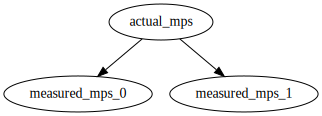

In [26]:
bn.graphviz_dag

In [27]:
factor = VE(
    network=bn,
    query=Query(
        outcomes=['actual_mps'],
        givens=[
            {
                'measured_mps_0': 1.0
            },
            {
                'measured_mps_1': 0.9
            },
        ]
    )
).compute()

In [28]:
factor.get_df()

,actual_mps,measured_mps_1,measured_mps_0,value
0,0.6,0.9,1.0,0.000005
1,0.7,0.9,1.0,0.001628
2,0.8,0.9,1.0,0.070071
3,0.9,0.9,1.0,0.430012
4,1.0,0.9,1.0,0.425992
5,1.1,0.9,1.0,0.070741
6,1.2,0.9,1.0,0.001544
7,1.3,0.9,1.0,0.000006


<AxesSubplot:xlabel='actual_mps'>

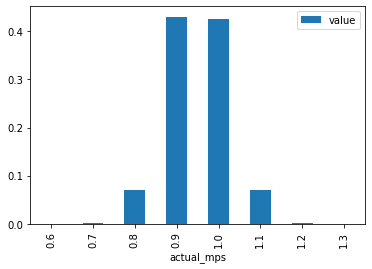

In [29]:
factor.get_df()[['actual_mps', 'value']].set_index('actual_mps').plot.bar()

In [153]:
def sample_total_air_delivery_rate(
    anemometer_readings,
    num_sections_per_layer = 12.0,
    num_feet_in_meters = 3.28084,
    num_layers = 3,
    no_air_flow_middle_diam_inches = 5.5,
    with_air_flow_inches = 8.0,
    sample_size = 10000
):
    """
    Sample total air delivery rate.
    """
    total = np.zeros(sample_size)

    for layer in range(num_layers):

        sq_ft_section = surface_area_of_layer_in_sq_ft(
            layer=layer,
            num_layers=num_layers,
            no_air_flow_middle_diam_inches=no_air_flow_middle_diam_inches,
            with_air_flow_inches=with_air_flow_inches
        ) / num_sections_per_layer

        for group in range(int(num_sections_per_layer)):
            wind_speed_readings_for_layer_group = anemometer_readings[
                (anemometer_readings['layer'] == layer) \
                & (anemometer_readings['group'] == group)
            ]

            reading_0 = wind_speed_readings_for_layer_group.iloc[0]['reading']
            reading_1 = wind_speed_readings_for_layer_group.iloc[1]['reading']
            query = Query(
                outcomes=['actual_mps'],
                givens=[
                    {
                        'measured_mps_0': reading_0
                    },
                    {
                        'measured_mps_1': reading_1
                    },
                ]
            )

            factor = VE(
                network=bn,
                query=query
            ).compute()

            result = factor.get_df()
            actual_windspeed_in_meters_per_second = \
                np.random.choice(
                    result['actual_mps'], 
                    p=result['value'], 
                    size=sample_size
                )

            actual_windspeed_in_feet_per_second = \
                actual_windspeed_in_meters_per_second * num_feet_in_meters

            mean_windspeed = actual_windspeed_in_feet_per_second.mean()
            total = total + actual_windspeed_in_feet_per_second * sq_ft_section
            
    return pd.Series(total)

<AxesSubplot:title={'center':'Total Air Delivery Rate of CR Microfiber'}, xlabel='Cubic Feet per Second', ylabel='Density'>

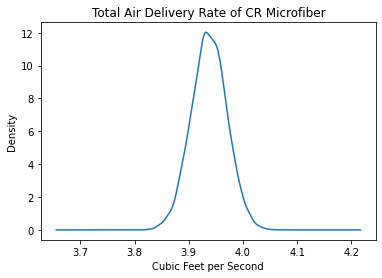

In [154]:
total = sample_total_air_delivery_rate(
    anemometer_readings=anemometer_readings
)
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Cubic Feet per Second')
pd.Series(total).plot.kde(title='Total Air Delivery Rate of CR Microfiber', ax=ax)

In [32]:
anemometer_readings['reading'].mean()

1.4416666666666667

Lit 3 matches, waited for a few minutes to ensure that the particle counter got a massive jump in readings (i.e. n0_3 jumped to 1800).

- Left at 8:01
- Turned on fan at 9:01
- Switched to Coway at 10:03
- Stopped data collection at 10:33

In [39]:
%%bash
pwd

/Users/eugaddan/Developer/linx/notebooks/air_cleaning_experiments


In [43]:
particle_counter_data = pd.read_json("pms_7003.json", orient='records', lines=True).set_index('datetime')

In [44]:
particle_counter_data

,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
datetime,,,,,,,,,,,,,
2021-12-18 19:53:27.899489,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:28.817320,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:29.655135,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:30.573125,0,0,0,0,0,0,6,2,1,1,0,0,0
2021-12-18 19:53:31.410849,0,0,0,0,0,0,6,2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-18 22:33:46.151964,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-18 22:33:47.005828,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-18 22:33:47.923702,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='datetime'>

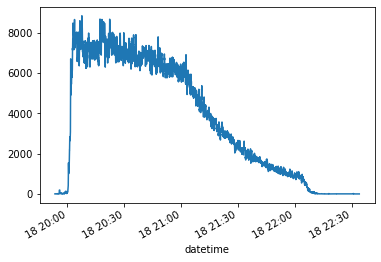

In [45]:
particle_counter_data['n0_3'].plot()

<AxesSubplot:xlabel='datetime'>

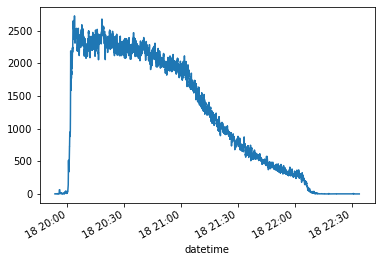

In [47]:
particle_counter_data['n0_5'].plot()

<AxesSubplot:xlabel='datetime'>

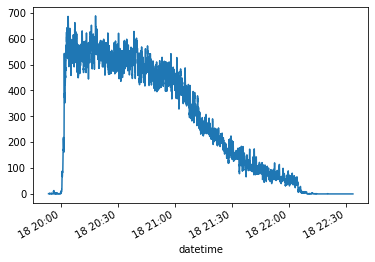

In [48]:
particle_counter_data['n1_0'].plot()

<AxesSubplot:xlabel='datetime'>

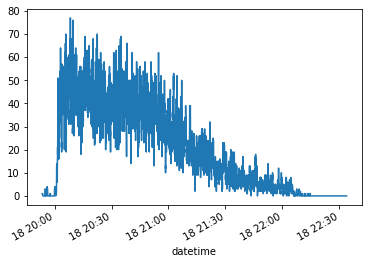

In [51]:
particle_counter_data['n2_5'].plot()

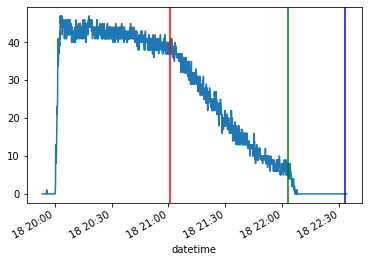

In [58]:
fig, ax = plt.subplots()
particle_counter_data['pm1_0'].plot(ax=ax)
ax.axvline("2021-12-18 21:01", color='r')
ax.axvline("2021-12-18 22:03", color='g')
ax.axvline("2021-12-18 22:33", color='b')

In [69]:
particle_reset = particle_counter_data.reset_index()

In [79]:
def time_at(time_str, df):
    time_str_plus_one_second = pd.to_datetime(time_str) + pd.Timedelta('1 second')
    
    return (df['datetime'] >= time_str) & \
        (df['datetime'] < time_str_plus_one_second)
    

In [76]:
pd.to_datetime('2021-12-18 21:01:00') + pd.Timedelta('1 second')

Timestamp('2021-12-18 21:01:01')

In [86]:
particle_reset[
    time_at('2021-12-18 21:04:00', df=particle_reset)
]

,datetime,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
4737,2021-12-18 21:04:00.179341,47,75,79,37,59,71,5457,1804,426,31,5,2,0


In [71]:
particle_reset[particle_reset['datetime'] > '2021-12-18 21:01']

,datetime,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
4537,2021-12-18 21:01:00.717187,52,84,87,40,63,76,6219,1969,478,40,3,1,0
4538,2021-12-18 21:01:01.619060,52,86,90,40,63,78,6234,1969,516,46,4,2,0
4539,2021-12-18 21:01:02.537044,52,84,90,40,63,78,6195,1957,527,42,4,2,0
4540,2021-12-18 21:01:03.438805,53,86,88,40,63,76,6354,1984,516,38,3,2,0
4541,2021-12-18 21:01:04.340676,55,86,88,41,63,76,6426,2009,514,34,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,2021-12-18 22:33:46.151964,0,0,0,0,0,0,0,0,0,0,0,0,0
10796,2021-12-18 22:33:47.005828,0,0,0,0,0,0,0,0,0,0,0,0,0
10797,2021-12-18 22:33:47.923702,0,0,0,0,0,0,0,0,0,0,0,0,0
10798,2021-12-18 22:33:48.777555,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
particle_counter_data['pm1_0']

datetime
2021-12-18 19:53:27.899489    0
2021-12-18 19:53:28.817320    0
2021-12-18 19:53:29.655135    0
2021-12-18 19:53:30.573125    0
2021-12-18 19:53:31.410849    0
                             ..
2021-12-18 22:33:46.151964    0
2021-12-18 22:33:47.005828    0
2021-12-18 22:33:47.923702    0
2021-12-18 22:33:48.777555    0
2021-12-18 22:33:49.695432    0
Name: pm1_0, Length: 10800, dtype: int64

In [67]:
720/3.8

189.47368421052633

In [65]:
1.0 - np.exp((720.0 / (3.8 * 3600)) * np.log(4)) 

-0.07569058622018243

In [66]:
 ((720.0 / 180) * np.log(1.0/9)) / np.log(0.0003)

1.083480390254976

In [87]:
1 - np.exp(1215.0 / (233.0 * 30.0) * np.log(1-0.996))

0.6170071333491278

In [89]:
(720.0 / (3600.0 * 3.8)) * np.log(1.0/4) / np.log(1-0.617)

0.07602513137100067

In [90]:
1.0 / 2.718

0.36791758646063283

In [91]:
0.9**3600

1.8751412236067268e-165

In [93]:
np.exp(sum([np.log(0.9) for i in range(3600)]))

1.8751412236327937e-165

In [94]:
def pm_actual(
    last_value,
    filtration_eff,
    decay,
    air_delivery_rate,
    room_volume,
):
    power = filtration_eff * air_delivery_rate / room_volume 
    return last_value * (1.0 - decay) ** power

In [97]:
def apply_recursive_pm(
    start_pm=100,
    filtration_eff=0.07,
    decay=0.617,
    air_delivery_rate=3.7,
    room_volume=720
):

    collection = [start_pm]

    for i in range(3599):

        new_value = pm_actual(
            last_value=collection[i],
            filtration_eff=filtration_eff,
            decay=decay,
            air_delivery_rate=air_delivery_rate,
            room_volume=room_volume,
        )

        collection.append(new_value)
    
    return pd.Series(collection)

In [186]:
collection = apply_recursive_pm(
    start_pm=40,
    filtration_eff=0.08,
    decay=0.617,
    air_delivery_rate=3.7,
    room_volume=720
)

In [187]:
pm_readings = particle_counter_data.reset_index()


In [188]:
microfiber = pm_readings[
    (pm_readings['datetime'] > '2021-12-18 21:01') & 
    (pm_readings['datetime'] <= '2021-12-18 22:01')
]

In [189]:
microfiber['datetime'].dt.hour

4537    21
4538    21
4539    21
4540    21
4541    21
        ..
8567    22
8568    22
8569    22
8570    22
8571    22
Name: datetime, Length: 4035, dtype: int64

In [190]:
microfiber.loc[:, 'rank'] = microfiber.groupby(
    [
        microfiber['datetime'].dt.hour,
        microfiber['datetime'].dt.minute,
        microfiber['datetime'].dt.second
    ]
)['datetime'].transform('rank').copy()

/Users/eugaddan/miniconda3/envs/linx_dev_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [191]:
only_one_reading = microfiber[microfiber['rank'] == 1].reset_index()

<AxesSubplot:>

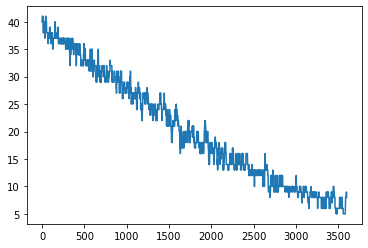

In [192]:
only_one_reading['pm1_0'].plot()

<AxesSubplot:>

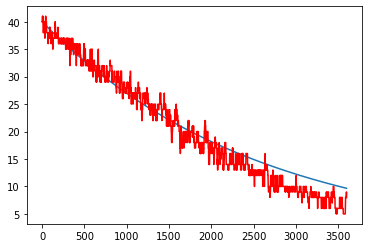

In [193]:
fig, ax = plt.subplots()
collection.plot(ax=ax)
only_one_reading['pm1_0'].plot(ax=ax, color='r')



<AxesSubplot:xlabel='datetime'>

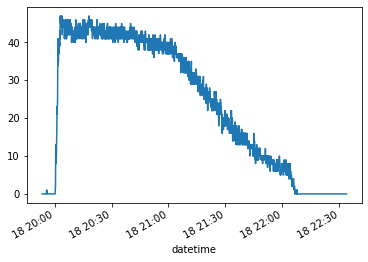

In [52]:
particle_counter_data['pm1_0'].plot()

<AxesSubplot:xlabel='datetime'>

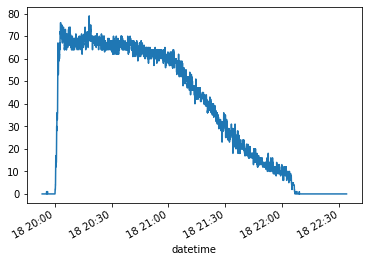

In [53]:
particle_counter_data['pm2_5'].plot()

<AxesSubplot:xlabel='datetime'>

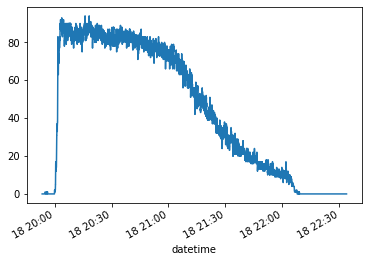

In [54]:
particle_counter_data['pm10'].plot()

<AxesSubplot:xlabel='datetime'>

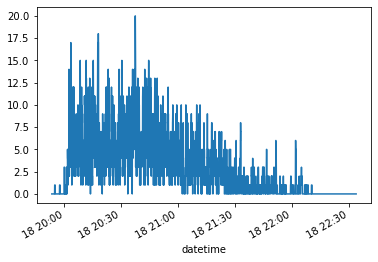

In [50]:
particle_counter_data['n5_0'].plot()

<AxesSubplot:xlabel='datetime'>

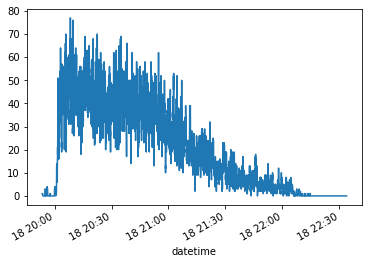

In [49]:
particle_counter_data['n2_5'].plot()

In [133]:
total_area = np.pi * ((5.5+8)/(2* 12))**2
no_airflow_area = np.pi * (5.5/(12 * 2))**2

avg_mps = anemometer_readings['reading'].mean()
avg_fps = avg_mps * 3.28
airflow_estimate = (total_area - no_airflow_area) * avg_fps

In [136]:
se = anemometer_readings['reading'].std() / np.sqrt(anemometer_readings.shape[0])
(airflow_estimate - se, airflow_estimate + se)

(3.8297710237678957, 4.010655219682763)

In [81]:
total_area - no_airflow_area

0.33406692713953967

## Calculate Air Delivery Rate of Coway AP-1512HH

In [ ]:
pd.DataFrame(
)

In [9]:
def cubic_feet_per_second(fs_of_layers, surface_areas_of_layers):
    """
    Parameters:
        fs_of_layers: np.array[float]
            Rate of airflow of each layer (Feet per second)
        surface_areas_of_layers: np.array[float]
            Surface area of each layer (Square feet)
            
    Returns: float
    """
    
    return (fs_of_layers * surface_areas_of_layers).sum()

In [10]:
round(1.2345,1)

1.2

In [11]:
# def create_airflow_rate_table():
#     collection = []
          
#     surface_areas_of_layers = [
#         surface_area_of_layer_in_sq_ft(i) for i in range(5)
#     ]
    
    
#     for layer_0_fs in np.arange(0, 15, 0.1):
#         layer_0_fs = round(layer_0_fs, 2)
        
#         for layer_1_fs in np.arange(0, 15, 0.1):
#             layer_1_fs = round(layer_1_fs, 2)
            
#             for layer_2_fs in np.arange(0, 15, 0.1):
#                 layer_2_fs = round(layer_2_fs, 2)
                
#                 for layer_3_fs in np.arange(0, 15, 0.1):
#                     layer_3_fs = round(layer_3_fs, 2)
                    
#                     for layer_4_fs in np.arange(0, 15, 0.1):
#                         layer_4_fs = round(layer_4_fs, 2)
                        
#                         fs_of_layers = np.array([
#                             layer_0_fs,
#                             layer_1_fs,
#                             layer_2_fs,
#                             layer_3_fs,
#                             layer_4_fs
#                         ])
                        
#                         cfs = cubic_feet_per_second(
#                             fs_of_layers, 
#                             surface_areas_of_layers
#                         )

#                         for layer, fs in enumerate(fs_of_layers):
#                             dictionary['flayer {layer} feet per second'] = fs
                            
#                         dictionary['cubic feet per second'] = round(cfs, 1)
#                         dictionary['value'] = 1
                        
#                         collection.append(dictionary)
                        
#                         for i in np.arange(0, 15, 0.1):
                        
                        

#     cfs = cubic_feet_per_second(
#         fs_of_layers, 
#         surface_areas_of_layers
#     )
    
#     dictionary['airflow'] = cfs

In [12]:
def least_significant_digit_power(num_string):
    if '.' in num_string:
        # There's a decimal point. Figure out how many digits are to the right
        # of the decimal point and negate that.
        return len(num_string.partition('.')[2])
    else:
        # No decimal point. Count trailing zeros.
        return len(num_string) - len(num_string.rstrip('0'))

In [13]:
least_significant_digit_power("0.123456")

6

In [156]:
def accuracy(mps):
    """
    Parameters:
        Reading in meters per second (m/s)
    """
    
    # m / s * 3.28084 ft / m
    #mps = reading * 3.28084
    val_1 = 0.03 * mps
    val_2 = mps - int(mps)
    # 20 ft/min * 1 min / 60 sec = 0.33 ft / sec
    val_3 = 0.33
    
    return max(val_1, val_2, val_3)
    
    

<AxesSubplot:>

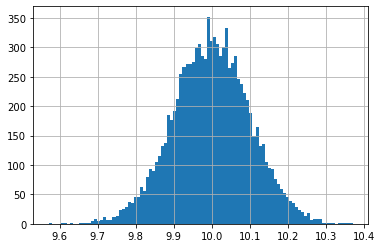

In [161]:
pd.Series(np.random.normal(10, 0.1, size=10000)).hist(bins=100)

In [176]:
def meters_to_feet(meters):
    return meters * 3.280 # feet per meter

In [180]:
def inches_to_feet(inches):
    return inches / 12.0

In [194]:
coway_mps = pd.DataFrame(
    [
        {'x': 0, 'y': 0, "measured_mps": 10.5},
        {'x': 0, 'y': 1, "measured_mps": 10.4},
        {'x': 0, 'y': 2, "measured_mps": 8.4},
        {'x': 1, 'y': 0, "measured_mps": 9.8},
        {'x': 1, 'y': 1, "measured_mps": 11.8},
        {'x': 1, 'y': 2, "measured_mps": 10.1},
        {'x': 2, 'y': 0, "measured_mps": 8.6},
        {'x': 2, 'y': 1, "measured_mps": 9.8},
        {'x': 2, 'y': 2, "measured_mps": 8.6},
        {'x': 3, 'y': 0, "measured_mps": 8.6},
        {'x': 3, 'y': 1, "measured_mps": 10.1},
        {'x': 3, 'y': 2, "measured_mps": 8.6},
    ]
)


def compute_cfps_rectangular_air_cleaner(
    num_sub_sections = coway_mps.shape[0],
    width_in=4.75,
    height_in=3.75,
    num_sims=10000
):
    """
    Parameters:
        num_sub_sections: integer
            Number of sub-sections in the rectangular area.
        total_area: float
            Total area in square inches.
        num_sims: integer
            Number of simulations
    """
    total = np.zeros(num_sims)
    sub_area = inches_to_feet(width_in) * inches_to_feet(height_in) / num_sub_sections

    for i, row in coway_mps.iterrows():
        total += np.random.normal(
            meters_to_feet(row['measured_mps']),
            0.1,
            size=num_sims
        ) * sub_area

    return pd.Series(total)


In [197]:
coway_cfps = compute_cfps_rectangular_air_cleaner(
    num_sub_sections = coway_mps.shape[0],
    width_in=4.75,
    height_in=3.75,
)

Text(0.5, 0, 'Cubic Feet per Second')

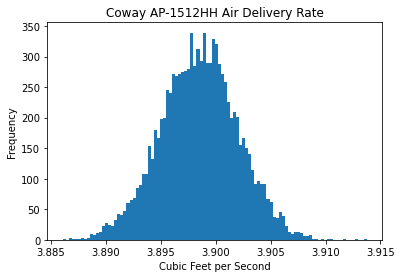

In [204]:
fig, ax = plt.subplots()
coway_cfps.plot.hist(
    bins=100,
    ax=ax
)
ax.set_title("Coway AP-1512HH Air Delivery Rate")
ax.set_xlabel("Cubic Feet per Second")

This aligns with the manufacturer's claim that this is good for 360 sq. ft (to get 4 ACH):

In [205]:

coway_cfps * 3600 / (360 * 10)

0       3.898472
1       3.897205
2       3.893967
3       3.899842
4       3.902866
          ...   
9995    3.897843
9996    3.900049
9997    3.903952
9998    3.898362
9999    3.905203
Length: 10000, dtype: float64

In [206]:
coway_cfps * 60

0       233.908311
1       233.832312
2       233.638049
3       233.990527
4       234.171938
           ...    
9995    233.870588
9996    234.002930
9997    234.237136
9998    233.901747
9999    234.312163
Length: 10000, dtype: float64

In [15]:
pd.cut([0.1, 0.9, 0.3], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0, 0.2, 0.4, 0.6, 0.8])

/Users/eugaddan/miniconda3/envs/linx_dev_env/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[0.0, 0.8, 0.2]
Categories (5, float64): [0.0 < 0.2 < 0.4 < 0.6 < 0.8]

In [ ]:
100 * 0.01**(2000.0/2000)

In [ ]:
i